# 유독 연동 서비스 불만콜 예측을 위한 PCA 및 분류 분석

## 1. 소개

유독 연동 서비스에서 발생하는 연동 오류로 인한 불만콜을 예측하고 분석하는 과정을 살펴보겠습니다. 우리의 목표는 다음과 같습니다:

1. 불만콜을 할 가능성이 높은 고객의 특성 파악
2. 데이터의 주요 패턴을 시각화하여 이해하기 쉽게 만들기
3. 불만콜 여부를 예측하는 모델 구축

이를 위해 주성분 분석(PCA)과 랜덤 포레스트 분류 모델을 사용할 것입니다.

## 2. 필요한 라이브러리 임포트 및 데이터 생성

먼저, 분석에 필요한 라이브러리들을 임포트하고 샘플 데이터를 생성해보겠습니다. 어떤 형태의 데이터가 필요한지 눈여겨 봐주세요.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 샘플 데이터 생성
np.random.seed(42)
num_samples = 10000

data = pd.DataFrame({
    'CustomerID': np.arange(1, num_samples + 1),
    'Age': np.random.randint(18, 80, num_samples),
    'OTTUsage': np.round(np.random.uniform(1, 100, num_samples)),
    'PlanType': np.random.choice(['Basic', 'Standard', 'Premium'], num_samples),
    'Region': np.random.choice(['Urban', 'Rural'], num_samples),
    'TabletUser': np.random.binomial(1, 0.3, num_samples),
    'SmartwatchUser': np.random.binomial(1, 0.2, num_samples),
    'ComplaintCall': np.random.binomial(1, 0.1, num_samples)
})

data.head()

,CustomerID,Age,OTTUsage,PlanType,Region,TabletUser,SmartwatchUser,ComplaintCall
0,1,56,70.0,Basic,Rural,0,0,1
1,2,69,94.0,Premium,Urban,0,0,0
2,3,46,100.0,Standard,Rural,0,0,0
3,4,32,46.0,Standard,Urban,0,0,0
4,5,60,26.0,Basic,Rural,0,1,0


1. 필요한 라이브러리를 임포트합니다.
2. 10,000개의 가상 고객 데이터를 생성합니다. 이 데이터는 고객 ID, 나이, OTT 사용량, 요금제 유형, 지역, 태블릿 사용 여부, 스마트워치 사용 여부, 불만콜 여부 등의 정보를 포함합니다.
3. 생성된 데이터의 처음 5행과 전체적인 정보를 출력합니다.

## 3. 데이터 탐색 (EDA)

데이터를 본격적으로 분석하기 전에, 먼저 데이터의 전반적인 특성을 이해하는 것이 중요합니다. 이를 위해 탐색적 데이터 분석(EDA)을 수행해보겠습니다.


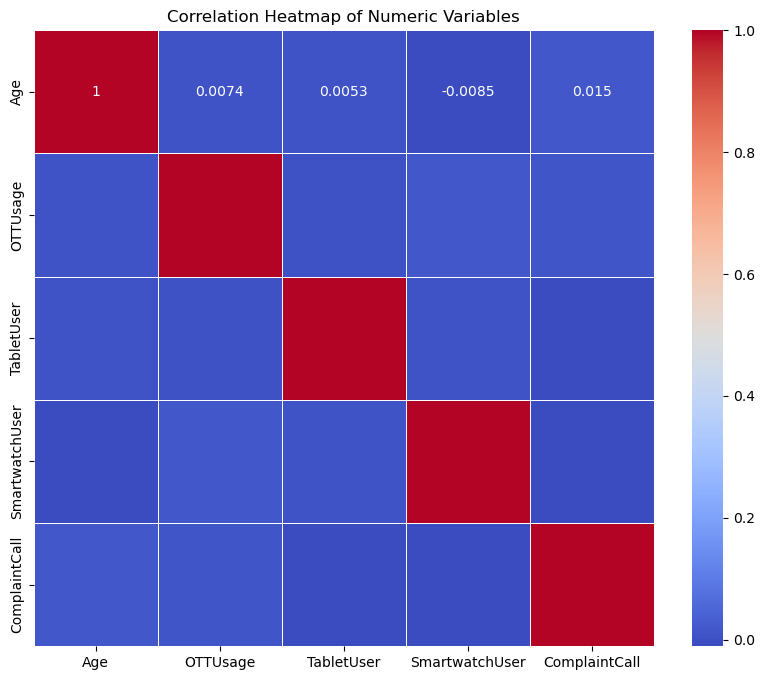

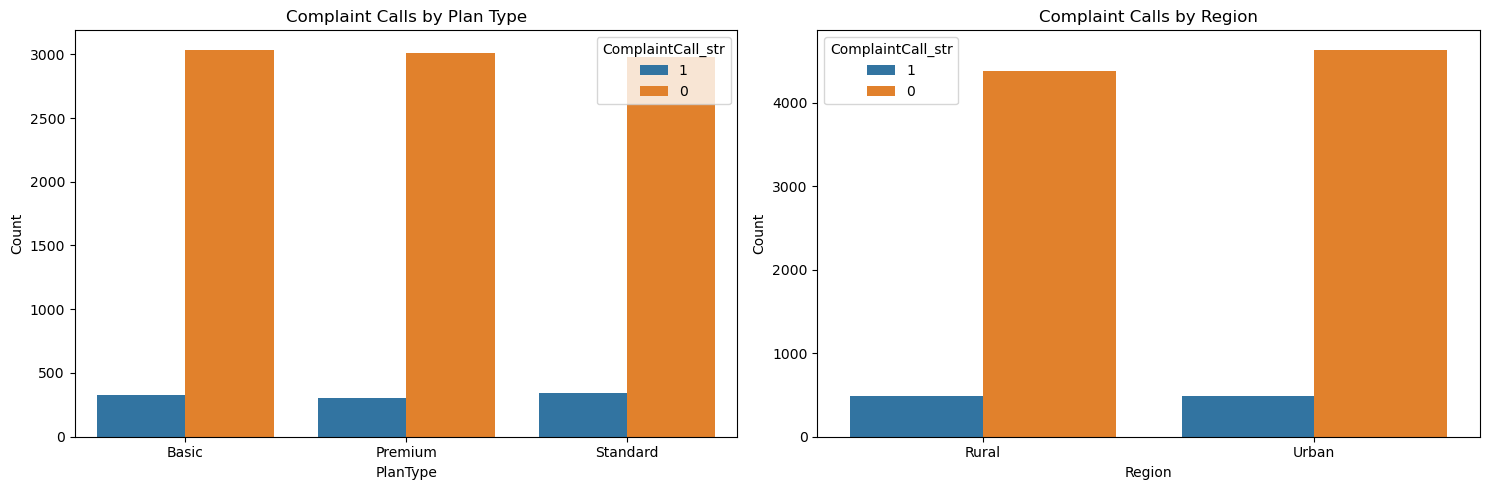

In [2]:
# 수치형 변수의 상관관계 분석
numeric_cols = ['Age', 'OTTUsage', 'TabletUser', 'SmartwatchUser', 'ComplaintCall']
correlation = data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

# 범주형 변수와 불만콜 관계 분석
data['ComplaintCall_str'] = data['ComplaintCall'].astype(str)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='PlanType', hue='ComplaintCall_str', data=data, ax=axes[0])
axes[0].set_title('Complaint Calls by Plan Type')
axes[0].set_ylabel('Count')

sns.countplot(x='Region', hue='ComplaintCall_str', data=data, ax=axes[1])
axes[1].set_title('Complaint Calls by Region')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


1. 수치형 변수들 간의 상관관계를 히트맵으로 시각화합니다. 이를 통해 변수들 간의 관계를 한눈에 파악할 수 있습니다.
2. 요금제 유형과 지역에 따른 불만콜 발생 빈도를 막대 그래프로 시각화합니다. 이를 통해 특정 요금제나 지역에서 불만콜이 더 많이 발생하는지 확인할 수 있습니다.

이러한 EDA 과정은 데이터의 특성을 이해하고, 이후의 분석 방향을 설정하는 데 도움을 줍니다.

## 4. PCA (주성분 분석)

주성분 분석(PCA)은 고차원의 데이터를 저차원으로 축소하는 기법입니다. 이를 통해 데이터의 주요 패턴을 파악하고 시각화할 수 있습니다. PCA는 다음과 같은 단계로 진행됩니다:

### 4.1 데이터 전처리

먼저 PCA를 적용하기 전에 데이터를 전처리해야 합니다.


In [3]:
# String으로 바꾸었던 열은 불필요하므로 제거함
data.drop('ComplaintCall_str', axis=1, inplace=True)

# 범주형 변수 인코딩
data_encoded = pd.get_dummies(data, columns=['PlanType', 'Region'], drop_first=True)

# 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded.drop(['CustomerID', 'ComplaintCall'], axis=1))

1. 범주형 변수(PlanType, Region)를 더미 변수로 인코딩합니다. 이는 범주형 변수를 수치형으로 변환하는 과정입니다.
2. 데이터를 스케일링합니다. 이는 모든 특성이 동일한 스케일을 가지도록 만드는 과정으로, PCA의 성능을 향상시킵니다.

### 4.2 초기 PCA 적용 및 Scree Plot 생성

다음으로, 모든 주성분을 사용하여 초기 PCA를 적용하고 Scree Plot을 생성합니다.


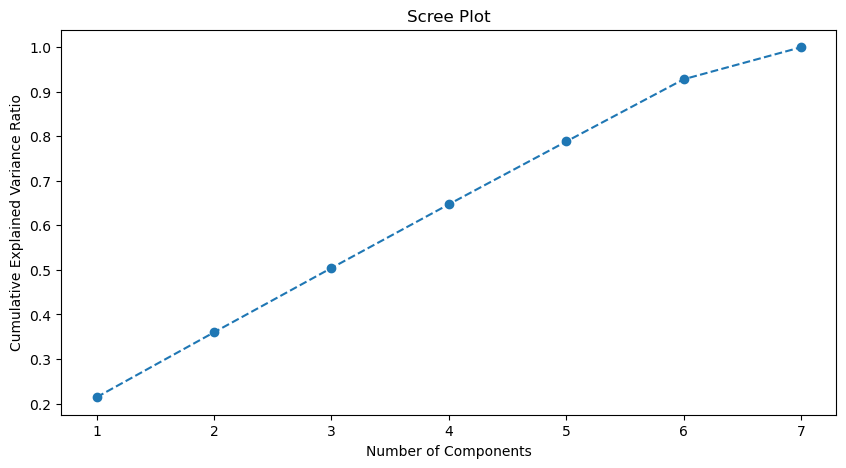

In [4]:
# 초기 PCA 적용 (모든 주성분)
pca_initial = PCA()
pca_initial.fit(scaled_data)

# Scree plot 생성
explained_variance_ratio = pca_initial.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()


Scree Plot은 각 주성분이 설명하는 분산의 비율을 누적하여 보여주는 그래프입니다. 이를 통해 몇 개의 주성분을 선택할지 결정할 수 있습니다.

### 4.3 적절한 주성분 수 선택

Scree Plot을 바탕으로 적절한 주성분의 수를 선택합니다. 일반적으로 plot이 꺾이는 지점을 선택합니다.


In [5]:
n_components = 3
print(f"\n선택된 주성분 수: {n_components}")


선택된 주성분 수: 3



### 4.4 선택된 주성분으로 PCA 다시 적용

선택된 주성분 수를 사용하여 PCA를 다시 적용합니다.


In [6]:
# 선택된 n_components로 PCA 다시 적용
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)


### 4.5 결과 시각화

PCA 결과를 시각화하여 데이터의 주요 패턴을 확인합니다.


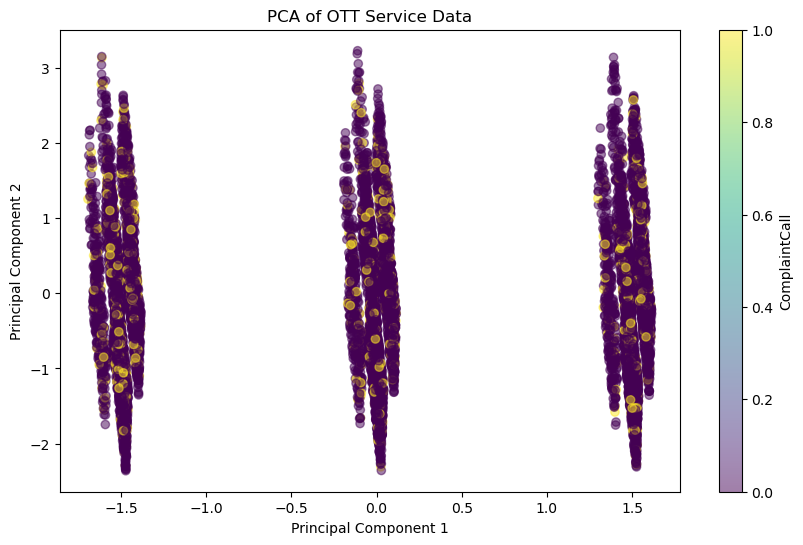


Explained Variance Ratio:
[0.21410803 0.14575803 0.14443492]


In [7]:
# 결과 시각화 (처음 두 주성분 사용)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data['ComplaintCall'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='ComplaintCall')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of OTT Service Data')
plt.show()

# 주성분의 설명 분산 비율
print("\nExplained Variance Ratio:")
print(pca.explained_variance_ratio_)


이 시각화를 통해 불만콜을 한 고객과 그렇지 않은 고객 사이의 전반적인 패턴 차이를 확인할 수 있습니다.

### 4.6 주성분 구성 확인

마지막으로, 각 주성분이 원래 변수들의 어떤 조합으로 이루어져 있는지 확인합니다.


In [8]:
# 주성분의 구성 확인
components_df = pd.DataFrame(
    pca.components_.T, 
    index=data_encoded.drop(['CustomerID', 'ComplaintCall'], axis=1).columns, 
    columns=[f'PC{i+1}' for i in range(n_components)]
)
components_df = components_df.round(4)
components_df = components_df.sort_values('PC1', key=abs, ascending=False)
print("\nPrincipal Components Composition:")
components_df


Principal Components Composition:


,PC1,PC2,PC3
PlanType_Premium,0.7056,0.0061,0.0423
PlanType_Standard,-0.7055,-0.0086,-0.0379
SmartwatchUser,-0.0487,0.2309,0.7375
Region_Urban,-0.0372,-0.5034,0.3118
OTTUsage,-0.0219,0.4749,0.3838
TabletUser,-0.0147,0.6004,-0.0820
Age,0.0043,0.3273,-0.4489



이를 통해 각 주성분이 어떤 원래 변수들로 주로 구성되어 있는지 이해할 수 있습니다.

## 5. 분류 분석 (랜덤 포레스트)

이제 불만콜 여부를 예측하는 분류 모델을 만들어보겠습니다. 여기서는 랜덤 포레스트 분류기를 사용합니다. 랜덤 포레스트는 여러 개의 결정 트리를 생성하고 그 결과를 종합하여 예측하는 앙상블 학습 방법입니다.

### 5.1 데이터 준비

먼저, 모델 훈련에 사용할 데이터를 준비합니다.


In [9]:
# 독립 변수와 종속 변수 설정
X = data_encoded.drop(['CustomerID', 'ComplaintCall'], axis=1)
y = data_encoded['ComplaintCall']

1. 독립 변수(X)와 종속 변수(y)를 설정합니다.
2. 독립 변수에서 'CustomerID'와 'ComplaintCall'을 제외합니다. 'CustomerID'는 예측에 의미가 없고, 'ComplaintCall'은 우리가 예측하고자 하는 대상이기 때문입니다.

### 5.2 데이터 분할

다음으로, 데이터를 훈련 세트와 테스트 세트로 나눕니다.


In [10]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. 데이터를 훈련 세트(80%)와 테스트 세트(20%)로 나눕니다.
2. random_state를 설정하여 결과의 재현성을 보장합니다.

### 5.3 모델 훈련

이제 랜덤 포레스트 모델을 훈련시킵니다.


In [11]:
# 모델 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)


1. RandomForestClassifier를 생성합니다. 여기서는 100개의 결정 트리를 사용합니다.
2. 훈련 데이터를 사용하여 모델을 훈련시킵니다.

### 5.4 예측 및 성능 평가

훈련된 모델을 사용하여 테스트 세트에 대한 예측을 수행하고, 모델의 성능을 평가합니다.


In [12]:
# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1810
           1       0.15      0.05      0.08       190

    accuracy                           0.88      2000
   macro avg       0.53      0.51      0.51      2000
weighted avg       0.84      0.88      0.86      2000


Confusion Matrix:
[[1755   55]
 [ 180   10]]



1. 테스트 세트에 대한 예측을 수행합니다.
2. 분류 보고서를 출력합니다. 이 보고서는 정확도, 정밀도, 재현율, F1 점수 등을 제공합니다.
3. 혼동 행렬을 출력합니다. 이는 실제 값과 예측 값의 분포를 보여줍니다.

### 5.5 특성 중요도 분석

마지막으로, 각 특성이 예측에 미치는 영향을 분석합니다.


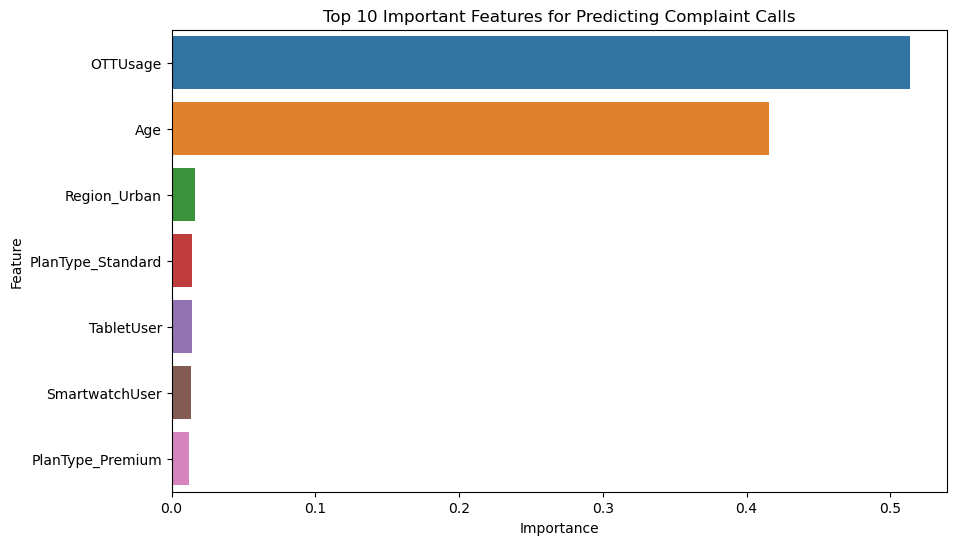

In [13]:
# 특성 중요도 시각화
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features for Predicting Complaint Calls')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

1. 각 특성의 중요도를 계산합니다.
2. 중요도가 높은 상위 10개 특성을 시각화합니다.
3. 이를 통해 어떤 요인이 불만콜 예측에 가장 중요한 영향을 미치는지 파악할 수 있습니다.

